In [198]:
import numpy as np
import regex as re
import pandas as pd
import networkx as nx

In [2]:
import requests

url_test = 'https://oda.ft.dk/api/Afstemning?$expand=Sagstrin/Sag&$filter=vedtaget eq true&$inlinecount=allpages'

r = requests.get(url_test)

sager = r.json()

In [3]:
#This function takes dict, extracts the next link, gets the new dict and appends it to the old dict

def get_all_pages(url):

    r = requests.get(url)

    sager = r.json()
    prev = r.json()

    while 'odata.nextLink' in prev:

        r = requests.get(prev['odata.nextLink'])
        sager['value'] += r.json()['value']
        prev = r.json()

    return sager

In [19]:
sager = get_all_pages(url_test)
sager.keys()

dict_keys(['odata.metadata', 'odata.count', 'value', 'odata.nextLink'])

In [20]:
#checking if all sager have the same keys
test = [len(sager['value'][i].keys()) for i in range(len(sager['value']))]
np.unique(test)

array([ 9, 10])

In [22]:
#they don't, so we check how many sager have missing keys
missing_keys = [i for i in range(len(sager['value'])) if len(sager['value'][i].keys()) != 10]
missing_keys

[0,
 1099,
 1100,
 1327,
 1404,
 1531,
 1532,
 1533,
 1542,
 1544,
 1550,
 1556,
 1559,
 1560]

In [23]:
#the above is only 14, so we remove those sager
clean_sager = [sag for sag in sager['value'] if len(sag) == 10]

In [81]:
clean_sager[0]['id']

2

In [79]:
clean_sager[0]['Sagstrin']['Sag'].keys()


dict_keys(['id', 'typeid', 'kategoriid', 'statusid', 'titel', 'titelkort', 'offentlighedskode', 'nummer', 'nummerprefix', 'nummernumerisk', 'nummerpostfix', 'resume', 'afstemningskonklusion', 'periodeid', 'afgørelsesresultatkode', 'baggrundsmateriale', 'opdateringsdato', 'statsbudgetsag', 'begrundelse', 'paragrafnummer', 'paragraf', 'afgørelsesdato', 'afgørelse', 'rådsmødedato', 'lovnummer', 'lovnummerdato', 'retsinformationsurl', 'fremsatundersagid', 'deltundersagid'])

In [136]:
#This function takes an id for a vote and collects all the votes for that vote

def get_all_votes(id):
    url = f'https://oda.ft.dk/api/Afstemning({id})/Stemme?$inlinecount=allpages'
    r = requests.get(url)
    votes = r.json()
    prev = r.json()
    while 'odata.nextLink' in prev:
        r = requests.get(prev['odata.nextLink'])
        votes['value'] += r.json()['value']
        prev = r.json()
        
    return votes


votes_test = get_all_votes(clean_sager[0]['id'])

In [137]:
votes_test['value']

[{'id': 180,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 158,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 181,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 126,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 182,
  'typeid': 2,
  'afstemningid': 2,
  'aktørid': 71,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 183,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 50,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 184,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 49,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 185,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 220,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 186,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 183,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 187,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 85,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 188,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 303,
  'opdate

In [177]:
#takes stemme-id which is id in stemme and returns info on the specific politician

def get_politician(id):
    
        url = f'https://oda.ft.dk/api/Stemme({id})/Akt%C3%B8r?$expand=Parti'
        r = requests.get(url)

        raw =  r.json()
        
        politician = dict()
        politician['navn'] = raw['navn']        
        party = re.search("<party>(.*?)<\/party>", raw['biografi']).group(1)
        politician['party'] = party

        return politician



        # we are only interested in typeid: 5, which is a person

test = get_politician(1)

test

{'navn': 'Eigil Andersen', 'party': 'Socialistisk Folkeparti'}

In [115]:
import pandas as pd
import numpy as np


import pandas as pd
def voting_df(data):
    df = pd.DataFrame()

    df['afstemnings_id'] = [x['id'] for x in data]
    df['sagstrin_id'] = [x['sagstrinid'] for x in data]
    df['vedtaget'] = [x['vedtaget'] for x in data]
    df['dato'] = [x['opdateringsdato'] for x in data]
    df['sag_id'] = [x['Sagstrin']['Sag']['id'] for x in data]
    df['titel']= [x['Sagstrin']['Sag']['titel'] for x in data]
    df['titel_kort'] = [x['Sagstrin']['Sag']['titelkort'] for x in data]
    df['lovnummer_num'] = [x['Sagstrin']['Sag']['nummernumerisk'] for x in data]
    df['lovnummer'] = [x['Sagstrin']['Sag']['nummer'] for x in data]
    df['resume']= [x['Sagstrin']['Sag']['resume'] for x in data]
    df['periode_id']= [x['Sagstrin']['Sag']['periodeid'] for x in data]

    return df
    

        
df_voting = voting_df(clean_sager)
df_voting.head()

,afstemnings_id,sagstrin_id,vedtaget,dato,sag_id,titel,titel_kort,lovnummer_num,lovnummer,resume,periode_id
0,2,4849,True,2014-09-09T09:25:05.717,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32
1,3,17351,True,2018-01-24T16:46:33.99,5604,"Folketinget konstaterer, at Danmark stod dårli...",Om rigets tilstand.,2,V 2,,31
2,4,18370,True,2018-01-25T10:25:25.64,5904,Forslag til lov om akutjob og jobpræmie til ar...,Om akutjob.,46,L 46,"Med loven etableres en midlertidig ordning, så...",31
3,5,4849,True,2017-08-10T12:57:52.27,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32
4,6,16581,True,2017-08-10T12:57:52.257,5384,Forslag til folketingsbeslutning om dansk mili...,Om dansk militært bidrag til støtte for indsat...,122,B 122,Med folketingsbeslutningen giver Folketinget s...,32


In [113]:
df["afstemnings_id"].values

array([   2,    3,    4, ..., 8999, 9000, 9001], dtype=int64)

In [171]:
#This function takes in a df of each vote and makes a dataframe of all the votes for each vote

def votes_df(voting_df):
    df = pd.DataFrame()

    #typeid: 1=ja, 2=nej, 3=blank, 4=fraværende

    df["afstemnings_id"] = voting_df["afstemnings_id"].values
    df["votes_combined_info"] = [get_all_votes(x)['value'] for x in voting_df['afstemnings_id']] #creates a dict
    
    [get_politician(votes_df["votes_combined_info"][0][i]['id']) for i in range(len(votes_df["votes_combined_info"][0]))]

    return df



    


In [172]:
votes_df = votes_df(df_voting)

In [297]:
votes_df["votes_combined_info"][0][0]['typeid']

1

In [303]:
#trying to count how many voted yes in total, not currently working...
count = 0
for i in range(len(votes_df["votes_combined_info"])):
    for j in votes_df["votes_combined_info"][i][j]:
        print(j)
        if votes_df["votes_combined_info"][i][j]['typeid'] == 1:
            count += 1
    print(i)


TypeError: list indices must be integers or slices, not str

In [193]:
#pickle dataframe
#import pickle
#
#with open('votes_df.pickle', 'wb') as f:
#    pickle.dump(votes_df, f)
    

In [174]:
votes_df["votes_combined_info"][0]

[{'id': 180,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 158,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 181,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 126,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 182,
  'typeid': 2,
  'afstemningid': 2,
  'aktørid': 71,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 183,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 50,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 184,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 49,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 185,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 220,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 186,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 183,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 187,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 85,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 188,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 303,
  'opdate

In [197]:
[get_politician(votes_df["votes_combined_info"][0][i]['id']) for i in range(len(votes_df["votes_combined_info"][0]))]

[{'navn': 'Eigil Andersen', 'party': 'Socialistisk Folkeparti'},
 {'navn': 'Kim Andersen', 'party': 'Venstre'},
 {'navn': 'Tom Behnke', 'party': 'Det Konservative Folkeparti'},
 {'navn': 'Liselott Blixt', 'party': 'Uden for folketingsgrupperne'},
 {'navn': 'Erling Bonnesen', 'party': 'Venstre'},
 {'navn': 'Morten Bødskov', 'party': 'Socialdemokratiet'},
 {'navn': 'Bent Bøgsted', 'party': 'Danmarksdemokraterne'},
 {'navn': 'Özlem Sara Cekic', 'party': 'Socialistisk Folkeparti'},
 {'navn': 'Anita Christensen', 'party': 'Dansk Folkeparti'},
 {'navn': 'Peter Christensen', 'party': 'Venstre'},
 {'navn': 'René Christensen', 'party': 'Dansk Folkeparti'},
 {'navn': 'Anne-Mette Winther Christiansen (udpeget af V)',
  'party': 'Venstre'},
 {'navn': 'Per Clausen', 'party': 'Enhedslisten'},
 {'navn': 'Jonas Dahl', 'party': 'Socialistisk Folkeparti'},
 {'navn': 'Lennart Damsbo-Andersen', 'party': 'Socialdemokratiet'},
 {'navn': 'Karina Lorentzen Dehnhardt', 'party': 'Socialistisk Folkeparti'},
 {'n

In [199]:
votes_df

,afstemnings_id,votes_combined_info
0,2,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '..."
1,3,"[{'id': 763789, 'typeid': 1, 'afstemningid': 3..."
2,4,"[{'id': 850407, 'typeid': 1, 'afstemningid': 4..."
3,5,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5..."
4,6,"[{'id': 164486, 'typeid': 1, 'afstemningid': 6..."
...,...,...
4822,8997,"[{'id': 2065910, 'typeid': 2, 'afstemningid': ..."
4823,8998,"[{'id': 2066089, 'typeid': 2, 'afstemningid': ..."
4824,8999,"[{'id': 2066268, 'typeid': 2, 'afstemningid': ..."
4825,9000,"[{'id': 2066447, 'typeid': 4, 'afstemningid': ..."


In [203]:
subset_votes = votes_df[0:10]

In [242]:
subset_votes["afstemnings_id"]

0     2
1     3
2     4
3     5
4     6
5     9
6    10
7    11
8    28
9    29
Name: afstemnings_id, dtype: int64

In [243]:
subset_votes["afstemnings_id"] = [str(num) + 'x' for num in subset_votes["afstemnings_id"].values]

C:\Users\rune7\AppData\Local\Temp\ipykernel_27000\1692368502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_votes["afstemnings_id"] = [str(num) + 'x' for num in subset_votes["afstemnings_id"].values]


In [206]:
subset_voting = df_voting[0:10]



In [234]:
subset_voting["afstemnings_id"] = [str(num) + 'x' for num in subset_voting["afstemnings_id"].values]

C:\Users\rune7\AppData\Local\Temp\ipykernel_27000\2829272704.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_voting["afstemnings_id"] = [str(num) + 'x' for num in subset_voting["afstemnings_id"].values]


In [235]:
subset_voting

,afstemnings_id,sagstrin_id,vedtaget,dato,sag_id,titel,titel_kort,lovnummer_num,lovnummer,resume,periode_id
0,2x,4849,True,2014-09-09T09:25:05.717,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32
1,3x,17351,True,2018-01-24T16:46:33.99,5604,"Folketinget konstaterer, at Danmark stod dårli...",Om rigets tilstand.,2,V 2,,31
2,4x,18370,True,2018-01-25T10:25:25.64,5904,Forslag til lov om akutjob og jobpræmie til ar...,Om akutjob.,46,L 46,"Med loven etableres en midlertidig ordning, så...",31
3,5x,4849,True,2017-08-10T12:57:52.27,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32
4,6x,16581,True,2017-08-10T12:57:52.257,5384,Forslag til folketingsbeslutning om dansk mili...,Om dansk militært bidrag til støtte for indsat...,122,B 122,Med folketingsbeslutningen giver Folketinget s...,32
5,9x,4856,True,2017-08-10T12:57:52.237,1451,Forslag til lov om ændring af lov om trafiksel...,Om Region Nordjyllands overtagelse af statens ...,136,L 136 B,"Med loven åbnes der mulighed for, at Region No...",32
6,10x,2500,True,2017-08-10T12:57:52.237,780,Forslag til lov om projektering af nyanlæg og ...,Om nyanlæg og hastighedsopgraderinger af jernb...,172,L 172,"Loven indeholder bemyndigelse til, at transpor...",32
7,11x,3939,True,2017-08-10T12:57:52.24,1118,Forslag til lov om ændring af lov om befordrin...,Om befordringsrabat til studerende ved videreg...,187,L 187,Befordringsordningerne for studerende ved de v...,32
8,28x,3846,True,2017-08-10T12:57:52.187,1110,"Forslag til lov om ændring af straffeloven, lo...","Om reorganisering af kriminalforsorgen, herund...",190,L 190,Loven er et led i udmøntningen af kriminalfors...,32
9,29x,3859,True,2017-08-10T12:57:52.193,1111,Forslag til lov om ændring af retsplejelov for...,Om ændring af den grønlandske retsplejelov.,191,L 191,Loven har til formål at gennemføre en række æn...,32


In [266]:
G = nx.Graph()
G.add_nodes_from(subset_voting['afstemnings_id'],bipartite=0)
for i in range(len(subset_votes)):
    
    for j in range(len(subset_votes["votes_combined_info"][i])):
        G.add_node(subset_votes["votes_combined_info"][i][j]['aktørid'], bipartite=1)
        if subset_votes["votes_combined_info"][i][j]['typeid'] == 1:
            G.add_edge(subset_votes["afstemnings_id"][i], subset_votes["votes_combined_info"][i][j]['aktørid'], weight = 1)

In [274]:

B = [node for node in G if node not in subset_voting['afstemnings_id'].values]

In [268]:
subset_votes["votes_combined_info"][0][0]['aktørid']

158

In [269]:
#mapping color to party names

subset_votes
    

,afstemnings_id,votes_combined_info
0,2x,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '..."
1,3x,"[{'id': 763789, 'typeid': 1, 'afstemningid': 3..."
2,4x,"[{'id': 850407, 'typeid': 1, 'afstemningid': 4..."
3,5x,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5..."
4,6x,"[{'id': 164486, 'typeid': 1, 'afstemningid': 6..."
5,9x,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9..."
6,10x,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1..."
7,11x,"[{'id': 163949, 'typeid': 1, 'afstemningid': 1..."
8,28x,"[{'id': 159653, 'typeid': 1, 'afstemningid': 2..."
9,29x,"[{'id': 159832, 'typeid': 1, 'afstemningid': 2..."


In [275]:
len(B)

201

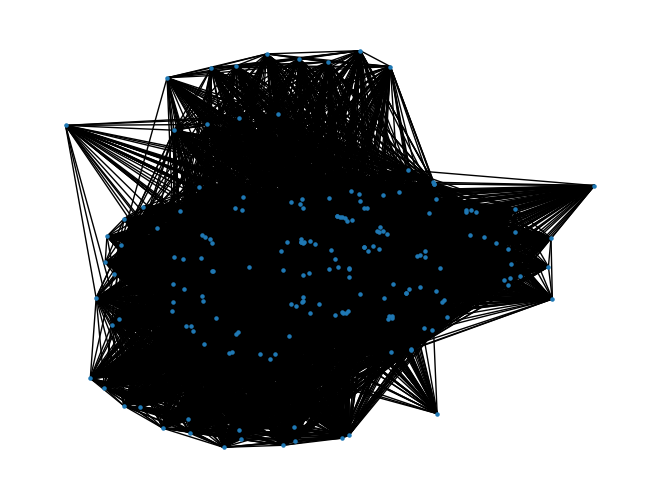

In [276]:
F = nx.bipartite.weighted_projected_graph(G, B)
F.remove_nodes_from(list(nx.isolates(F)))
nx.draw(F, node_size = 5)

In [277]:
degree_list = []
for node in F.nodes():
    degree_list.append(F.degree(node))

# normalize node size to highest degree with max size = 30
max_degree = max(degree_list)
node_size_list = [x/max_degree*200 for x in degree_list]

In [278]:
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt

100%|██████████| 500/500 [00:00<00:00, 805.07it/s]


BarnesHut Approximation  took  0.08  seconds
Repulsion forces  took  0.41  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.09  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


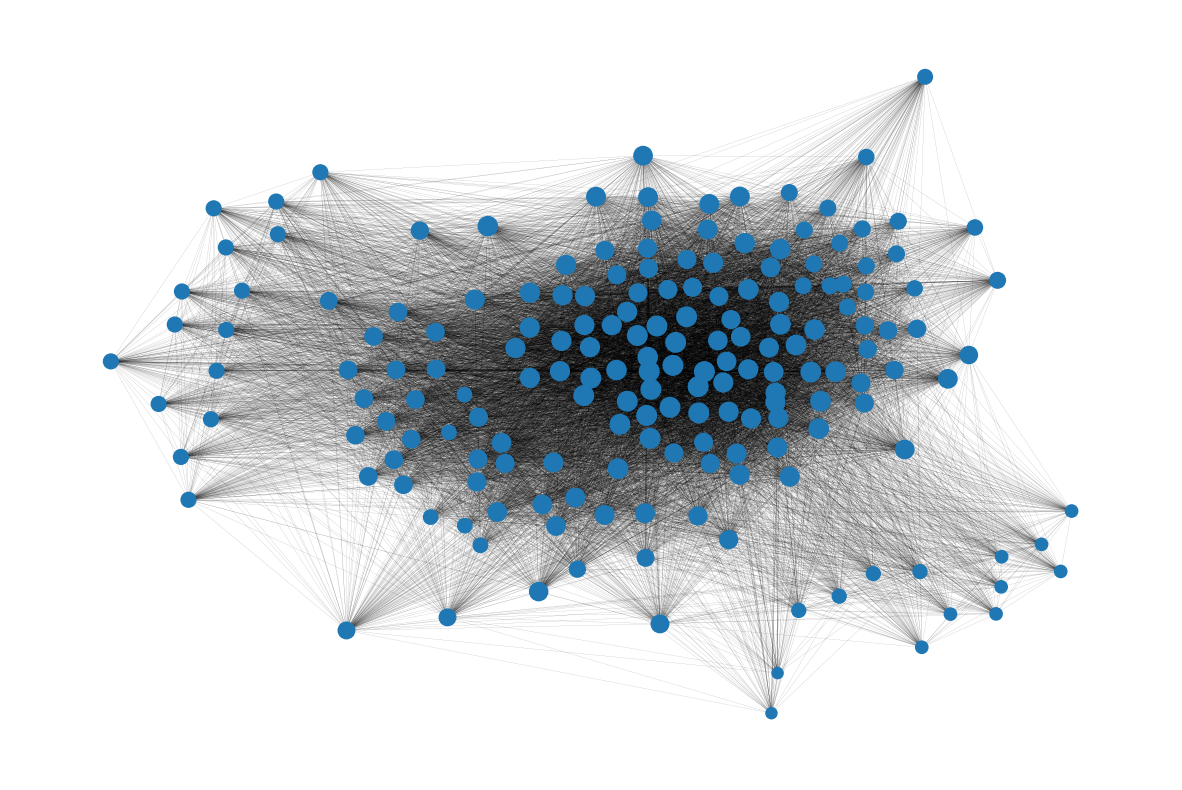

In [279]:
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1,

    # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1,
                        strongGravityMode=True,
                        gravity=5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(
    F, pos=None, iterations=500)

fig, ax = plt.subplots(figsize=(15, 10))
nx.draw(F, pos=positions, with_labels=False, node_size=node_size_list,
        width=0.05)